In [5]:
# Undersample and plot imbalanced dataset with the Edited Nearest Neighbor rule
from collections import Counter


from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection,EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

from matplotlib import pyplot
from numpy import where
import numpy as np
from numpy import mean
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from plot_functions import AccLossPlotter

In [6]:
# load dataset
dataframe = pd.read_csv("KidneyStoneDataset.csv", header=None) # return numpy array
dataset = dataframe.values


In [7]:

# split into input (X) and output (Y) variables
X = dataset[:,0:5120]
Y = dataset[:,5120]
#verileri normalize etmesem de sonuç değişmiyor
normalized_X = preprocessing.normalize(X) 
print(normalized_X)
print(Y)
print(X.shape)

[[0.         0.00013497 0.00647841 ... 0.00593854 0.         0.        ]
 [0.         0.00027323 0.00683076 ... 0.00560123 0.         0.00013662]
 [0.         0.00027786 0.00736317 ... 0.00444569 0.         0.00013893]
 ...
 [0.         0.00055658 0.00041744 ... 0.         0.         0.        ]
 [0.00040583 0.00067639 0.0017586  ... 0.         0.         0.        ]
 [0.00079405 0.00052937 0.00277919 ... 0.         0.         0.        ]]
[1 1 1 ... 1 1 1]
(1783, 5120)


In [8]:
X = np.array(normalized_X) 
y = np.array(Y)



In [9]:
model=Sequential()
model.add(Dense(32,input_dim=5120))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.2))

model.add(Activation('relu'))
model.add(Dense(64))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('softmax'))

class_names = ['Healthy', 'Patient']


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [28]:
def plot_confusion_matrix(cm, names,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=None)
print('Train size:  %d' % len(trainX))
print('Test size:  %d'% len(testX))

Train size:  1426
Test size:  357


In [31]:
n_splits=5
#split sayısı doğruluğu değiştirmiyor.
skf = StratifiedKFold(n_splits=n_splits,random_state=42,shuffle=True)
cm=0
precision=0
recall=0
f1=0
cvscores = []

for train_index, test_index in skf.split(trainX, trainy):
   
    print(f"train (%) {np.sum(y[train_index])/len(train_index)} \t test(%): {np.sum(y[test_index])/len(test_index)}")
    model.fit(X[train_index,:], y[train_index], \
                  validation_data=(X[test_index,:], \
                  y[test_index]), epochs=100,batch_size=32, verbose=0)
    scores= model.evaluate(X[test_index],Y[test_index],verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    pred=model.predict(X[test_index,:])
    precision = precision+ precision_score(y[test_index], pred)
    recall = recall+ recall_score(y[test_index], pred)
    f1=f1+f1_score(y[test_index],pred)
    cm =cm + confusion_matrix(y[test_index], pred)
    pred = np.argmax(pred,axis=1)


train (%) 0.4342105263157895 	 test(%): 0.45454545454545453
acc: 45.45%
train (%) 0.43382997370727433 	 test(%): 0.45614035087719296
acc: 45.61%
train (%) 0.43207712532865905 	 test(%): 0.4631578947368421
acc: 46.32%
train (%) 0.45223488168273446 	 test(%): 0.3824561403508772
acc: 38.25%
train (%) 0.43908851884312006 	 test(%): 0.43508771929824563
acc: 43.51%


In [ ]:
# history=model.fit(trainX, trainy, \
#                    validation_data=(testX, \
#                    testy), epochs=100,batch_size=32)
# plt.plot(history.history['acc'], label='accuracy')
# plt.plot(history.history['val_acc'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(testX, testy, verbose=2)


In [32]:

precision=precision/n_splits
print('Precision: %.3f' % precision)
recall=recall/n_splits
print('Recall: %.3f' % recall)
f1=f1/n_splits
print('F1 Score: %.3f' % f1)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
# plot_confusion_matrix(cm, class_names)

Precision: 0.438
Recall: 1.000
F1 Score: 0.609
Confusion matrix
[[  0 801]
 [  0 625]]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Precision: 0.515
Recall: 1.000
F1 Score: 0.680
Confusion matrix
[[  0 173]
 [  0 184]]


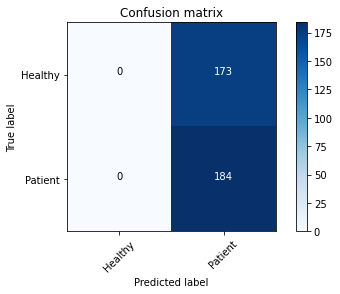

In [20]:
y_pred = model.predict(testX)
precision = precision_score(testy, y_pred)
print('Precision: %.3f' % precision)
recall = recall_score(testy, y_pred)
print('Recall: %.3f' % recall)
f1=f1_score(testy,y_pred)
print('F1 Score: %.3f' % f1)


cm = confusion_matrix(testy, y_pred)

print('Confusion matrix')
print(cm)
plt.figure()
class_names = ['Healthy', 'Patient']
plot_confusion_matrix(cm, class_names)